In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [0]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# data
var = 0.2
def func(x):
    return x

def gen_x():
    return np.sign(np.random.normal(0.,1.,[data_size,1]))

def gen_y(x):
    return func(x)+np.random.normal(0.,np.sqrt(var),[data_size,1])

In [4]:
data_size = 1000000
x=gen_x()
y=gen_y(x)
p_y_x=np.exp(-(y-x)**2/(2*var))
p_y_x_minus=np.exp(-(y+1)**2/(2*var))
p_y_x_plus=np.exp(-(y-1)**2/(2*var))
mi=np.average(np.log(p_y_x/(0.5*p_y_x_minus+0.5*p_y_x_plus)))
mi

0.6584722429705817

In [5]:
H=10
n_epoch = 500
data_size = 20000

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(1, H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2    

model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
plot_loss = []
for epoch in tqdm(range(n_epoch)):
    x_sample=gen_x()
    y_sample=gen_y(x_sample)
    y_shuffle=np.random.permutation(y_sample)
    
    x_sample = Variable(torch.from_numpy(x_sample).type(torch.FloatTensor), requires_grad = True)
    y_sample = Variable(torch.from_numpy(y_sample).type(torch.FloatTensor), requires_grad = True)
    y_shuffle = Variable(torch.from_numpy(y_shuffle).type(torch.FloatTensor), requires_grad = True)    
    
    pred_xy = model(x_sample, y_sample)
    pred_x_y = model(x_sample, y_shuffle)

    ret = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
    loss = - ret  # maximize
    plot_loss.append(loss.data.numpy())
    model.zero_grad()
    loss.backward()
    optimizer.step()

100%|██████████| 500/500 [00:15<00:00, 31.37it/s]


In [0]:
plot_x = np.arange(len(plot_loss))
plot_y = np.array(plot_loss).reshape(-1,)

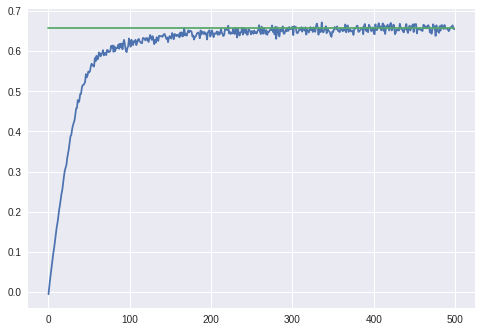

In [7]:

plt.plot(plot_x, -plot_y)
plt.plot(plot_x, mi*np.ones(len(plot_loss)))
plt.show()